## Diseño Evolutivo de Redes Neuronales Artificiales
## Evolutionary Design of Artificial Neural Networks
## DERNA/EDANN
Some code based on [Time Series Prediction A Naive Exploration](https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf)

The objective of this program is to optimize the published code (baseline_tolentino_original) using EDANN.<br>
On the paper, Tolentino achieves a Test loss of 0.10234724577159098<br>
My implementation of the program achieves 0.06509439647197723<br>
The objective of this program is to outperform those numbers.<br>
This version tries to optimize neurons, window and batch_size.

V 1.0 2020-08-11 Complete rewrite of EDANN, it now uses real genes, mapping, alpha blend y gaussian perturbation mutation.

V 1.1 Implements three types of genes: integer, real and ordinal.

Parte del código está basado en [Time Series Prediction A Naive Exploration](https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf)

El objetivo de este programa es optimizar el código publicado (baseline_tolentino_original) usando DERNA.<br>
En el artículo, Tolentino logra una pérdida de prueba de 0.10234724577159098<br>
Mi implementación de su programa logra 0.06509439647197723<br>
El objetivo de este programa es mejorar ese número.<br>
Esta versión trata de optimizar el número de neuronas, el tamaño de la ventana y el tamaño del lote.

V 1.0 2020-08-11 Reescritura completa de cero de DERNA, ahora usa genes reales, mapeo, alpha blend y mutación por perturbación gausiana.

V 1.1 Implementa tres tipos de genes: enteros, reales y ordinales.

### Configuración
### Setup

#### Instalación de paquetes
#### Install packages

In [ ]:
!pip install -U deap

     |████████████████████████████████| 163kB 4.1MB/s 


##### Importar librerías y funciones
##### Import libraries and functions

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from deap import base, creator, tools, algorithms

#### Hiperparámetros
#### Hyperparameters

In [ ]:
p = {
     # RNA/ANN
     "Window": 149,  # ventana de trasposición
     # transposition window
     "Neurons": 18,  # neuronas de la capa escondida
     # hidden layer neurons
     "activation": "relu",  # de la capa escondida/of the hidden layer
     # puede ser/could be: relu, sigmoid, softmax, softplus, softsign, tanh,
     # selu, elu, exponential, or linear
     "output_activation": "linear",  # de la capa de salida/of the output layer
     
     # entrenamiento/training
     "loss": "mse",  # puede ser/could be: mse, mae, msle, cs, huber,
     # or logcosh
     "optimizer": "adamax",  # puede ser/could be: sgd, rmsprop, adam, adadelta,
     # adagrad, adamax, nadam, or ftrl
     # o una instancia de una clase con parámetros como
     # or a class instance with sub-parameters like
     # tf.keras.optimizers.SGD(
     #    learning_rate=0.3,
     #    momentum=0.2,
     #    nesterov=False),
     "test_split" : 0.20,  # 20% para prueba/for testing
     "val_split" : 0.20,  # 20% para validación/for validation
     "epochs": 10,  # épocas de entrenamiento durante la optimización
     # training epochs during optimization
     "batch_size": 71,  # tamaño del lote
     # batch lot size
     "shuffle": True,  # mezclar los datos de entrenamiento/the training data
     "verbose": 0,  # entrenamiento verboso, 1 es mucho, puede ser mejor 2
     # verbose training, 1 is too chatty, 2 may be convenient

     # AG/GA
     "population" : 25,  # número de individuos en la población
     # debe escogerse basado en el tamaño del espacio a optimizar
     # entre más alto mejor cerca de sqrt(tamaño del espacio)
     # number of individuals in population
     # should be chosen based on the size of the optimization space
     # (better high around sqrt(space size))
     "ngen" : 15,  # número de generaciones (suficiente para que converga)
     # DERNA no hace evaluaciones redundantes, por lo que no es peligroso
     # un número alto
     # number of generations (just high enough)
     # EDANN does no redundant evaluations so a high value is not a problem
     "alpha" : 0.2,  # sobrepeso del alpha blend (no debe ser muy alto)
     # alpha blend oversize (better not too high)
     "sigma": 0.1,  # para la mutación gausiana
     # for gaussian mutation
     "indpb": 0.2,  # para la mutación gausiana
     # for gaussian mutation
     "tournsize" : 3,  # tamaño del torneo
     # tournament size
     "cxpb" : 0.6,  # probabilidad de cruce (mejor alta)
     # crossover probability (better high)
     "mutpb" : 0.01,  # probabilidad de mutación (mejor baja)
     # mutation probability (better low)

     # optimizador/optimizer
     "ngenes" : 3,  # número de genes en el cromosoma
     # number of genes in a chromosome
     "genes" : ("Window", "Neurons", "batch_size"),
     "min" : (1, 1, 10),  # mínimo valor de cada gen
     # minimun value of each gene
     "range" : (200, 30, 100),  # rango de valores de cada gen
     # range of values of each gene
     "type" : ("I", "I", "I"),  # tipo de cada gen, I entero, Real, Ordinal
     # type of gene Integer, Real, Ordinal
     "list" : ([], [], []),  # lista de valores para los genes ordinales
     # list of values for ordinal genes
    }

#### Leer los datos del repositorio
#### Read data from repository

In [ ]:
# copiar el archivo del repositorio
# copy file from repository
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )
# cargar los datos en un dataframe Pandas
# load data into a Pandas dataframe
df = pd.read_csv(path_to_downloaded_file)
print(len(df), "lines read")

335872/328946 [==============================] - 0s 0us/step
4829 lines read


#### Agregar nuevas columnas y eliminar las que no se van a usar
#### Add new columns and drop unused ones

In [ ]:
df.drop(["Date", "Open", "High", "Low", "Volume"], axis=1, inplace=True)

#### Separar los datos en entrenamiento y prueba
#### Split data into train and test sets

In [ ]:
# MinMaxScaler requiere arreglos Numpy bidimensionales
# MinMaxScaler requires 2D Numpy Arrays
test_split = int(len(df) * (1.0 - p["test_split"]))
train = df.iloc[:test_split].values.reshape(-1,1)
test = df.iloc[test_split:].values.reshape(-1,1)

#### Escalar los datos a [0, 1]
#### Scale data to [0, 1]

In [ ]:
scaler = skp.MinMaxScaler(feature_range=(0, 1))
# se escala solo con los datos de entrenamiento para evitar fuga de datos
# it should not fit using both arrays, use only train to avoid data leak
scaler.fit(train)
train_scaled = scaler.transform(train).flat
test_scaled = scaler.transform(test).flat

#### Definición de funciones auxiliares
#### Auxiliary functions definition

##### Covertir la serie de tiempo en ventanas deslizantes
##### Convert the time series into sliding windows

In [ ]:

def prepare_time_series(time_series, targets, window):
    """Prepara la serie de tiempo para Keras
    como tf.keras.preprocessing.sequence.TimeseriesGenerator
    pero sin crear los lotes
    En el caso más básico time_series y targets son el mismo arreglo

    Prepare time series and targets for Keras
    like tf.keras.preprocessing.sequence.TimeseriesGenerator
    without the batches
    In the basic case time_series and targets are the same array

    Args:
    time_series: flat array-like: of values of the time series
    targets: flat array-like: of target values
    X[0] = time_series[0:window]
    Y[0] = targets[window]
    
    Returns:
    X: 2D ndarray: of dataset_length vectors of window elements
    Y: 1D ndarray: of targets[window:]
    """

    dataset_length = len(time_series) - window
    X = np.empty((dataset_length, window))
    Y = np.empty((dataset_length, 1))
    for i in range(dataset_length):
        X[i, :] = time_series[i:(i + window)]
        Y[i, 0] = targets[i + window]
    return X, Y



##### Crear, entrenar y probar la RNA
##### Create train and test an ANN

In [ ]:

def create_ann(p, train_data, targets):
    """Crea una RNA con los parámetros de p y la entrena con train_data
    Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    train_data: flat array-like: of training data
    targets: flat array-like: of targets
    
    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    """

    X_train, y_train = prepare_time_series(
        train_data, targets, p["Window"])

    # asegura reproducibilidad y consistencia de los fenotipos
    # ensure reproducibility and consistency across fenotypes
    tf.random.set_seed(31415926)  # Keras

    ann = Sequential([Dense(units=p["Neurons"],
                            input_dim=p["Window"],
                            activation=p["activation"]),
                      Dense(units=1,
                            activation=p["output_activation"])])

    ann.compile(loss=p["loss"], optimizer=p["optimizer"])

    history = ann.fit(x=X_train,
                      y=y_train,
                      epochs=p["epochs"],
                      batch_size=p["batch_size"],
                      verbose=p["verbose"],
                      validation_split=p["val_split"],
                      shuffle=p["shuffle"])
    
    return ann, history



##### Crear y evaluar la RNA descrita por un cromosoma
##### Create and evaluate the ANN described by a chromosome

In [ ]:

def evaluate_chromosome(chromosome, p=None, train_data=None, targets=None,
                        seen_fenotypes=None):
    """Construir, entrenar y evaluar la RNA descrita por un cromosoma
    - Extraer el fenotipo del cromosoma
    - Si ya ha sido evaluado, devolver la pérdida inmediatamente
    - si no, crear la RNA, entrenarla y evaluarla
    - finalmente guardar los errores de entrenamiento y validación

    Build, train and evaluate the ANN represented by a chromosome
    - Extract the fenotype from the chromosome
    - If it has been previously evaluated return the loss immediately
    - otherwise create train and evaluate the ann
    - finally save the training and validation loss

    Args:
    chromosome: list of genes: each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters
    train_data: flat array-like: data for training
    targets: flat array-like: targets for training
    seen_fenotypes: dictionary: evaluated fenotypes and their losses

    Returns:
    (float,): Validation loss
    """

    # extracción del fenotipo
    # fenotype extraction
    fenotype=[]
    for i in range(p["ngenes"]):
        j = chromosome[i] * p["range"][i] + p["min"][i]
        if p["type"][i] == "I":
            fenotype.append(int(j))
        elif p["type"][i] == "R":
            fenotype.append(j)
        else:
            fenotype.append(p["list"][int(j)])

    fenotype = tuple(fenotype)

    # configuración de hiperparámetros
    # set hyperparameters
    for i in range(p["ngenes"]):
        p[p["genes"][i]] = fenotype[i]

    # muestra el fenotipo
    # show fenotype
    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")

    # evita evaluar de nuevo
    # avoid evaluating the same fenotype twice
    if fenotype in seen_fenotypes:
        return seen_fenotypes[fenotype][1], # 0 = val_loss, 1 = loss

    # construye la RAN
    # build the ANN
    model, history = create_ann(p, train_scaled, train_scaled)

    # extrae y despliega los errores
    # extract and display training and validation loss
    val_loss = history.history["val_loss"][-1]
    loss = history.history["loss"][-1]
    print("Training error: {} Validation error: {}".format(loss, val_loss))

    # finalmente guarda los errores
    # finally, save the losses
    seen_fenotypes[fenotype] = val_loss, loss
    # puede escoger loss o val_loss
    # can be loss or val_loss
    return loss,



#### Crea la definición de ajuste
#### Create the fitness definition

In [ ]:
# normalmente fitness trata de maximizar, se usa peso negativo para maximizar
# fitness normally tries to maximize we use negative weight to minimize
#creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

#### Definir el resto de los operadores genéticos en el toolbox
#### Define the rest of the genetic operators on the toolbox

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=p["ngenes"])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    """Decorador para ajustar el valor del gen si se sale de rango
    Decorator to adjust the gene value in case it is out of bounds

    Args:
    min: minimum value
    max: maximum value

    Returns:
    The function that checks bounds to decorate mate or mutate on the toolbox
    """

    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# mate by Alpha Blend
toolbox.register("mate", tools.cxBlend, alpha=p["alpha"])
# stay within [0,1)
toolbox.decorate("mate", checkBounds(0.0, 0.9999999999999999))
# mutate by gaussian perturbation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=p["sigma"],
                 indpb=p["indpb"])
# stay within [0,1)
toolbox.decorate("mutate", checkBounds(0.0, 0.9999999999999999))
toolbox.register("select", tools.selTournament, tournsize=p["tournsize"])
# initialize seen list to avoid multiple evaluations
seen_fenotypes = {}
toolbox.register("evaluate", evaluate_chromosome, p=p, train_data=train_scaled,
                 targets=train_scaled, seen_fenotypes=seen_fenotypes)



### El Algoritmo Genético
### The Genetic Algorithm

### Ejecuta el AG
#### Run the GA

In [ ]:
# siembra el generador aleatorio para asegurar reproducibilidad
# seed the random generator to ensure reproducibility
random.seed(31416) # DEAP/EDANN

seen_fenotypes = {}

population = toolbox.population(n=p["population"])
algorithms.eaSimple(population, toolbox, cxpb=p["cxpb"], mutpb=p["mutpb"],
                        ngen=p["ngen"], verbose=True)

Window 102 Neurons 30 batch_size 75 
Training error: 0.000852809811476618 Validation error: 0.0008277554879896343
Window 173 Neurons 14 batch_size 81 
Training error: 0.001764450455084443 Validation error: 0.001611905638128519
Window 106 Neurons 21 batch_size 10 
Training error: 0.0006649498245678842 Validation error: 0.0007111638551577926
Window 92 Neurons 26 batch_size 76 
Training error: 0.0009472828824073076 Validation error: 0.0010170337045565248
Window 48 Neurons 18 batch_size 46 
Training error: 0.0007652969798073173 Validation error: 0.0007055287132970989
Window 191 Neurons 17 batch_size 29 
Training error: 0.0009213487501256168 Validation error: 0.0016043735668063164
Window 198 Neurons 16 batch_size 33 
Training error: 0.0010021744528785348 Validation error: 0.001691729761660099
Window 166 Neurons 19 batch_size 66 
Training error: 0.0010212124325335026 Validation error: 0.0010695286327973008
Window 57 Neurons 1 batch_size 61 
Training error: 0.002096515381708741 Validation err

#### Muestra las mejores soluciones
#### Show the best solutions

In [ ]:
best_individuals = tools.selBest(r, k=len(r))
# extraer los mejores fenotipos
# extract best fenotype
best_ann = tuple(
    [int(best_individuals[0][i] * p["range"][i] + p["min"][i])
    for i in range(len(best_individuals[0]))])
best_window_size = best_ann[0]

for chromosome in best_individuals:
    fenotype = tuple(
        [int(chromosome[i] * p["range"][i] + p["min"][i])
        for i in range(len(chromosome))])
    
    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")

Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 41 
Window 6 Neurons 21 batch_size 40 


#### Entrenar y probar al mejor individuo
#### Train the best individual and test it

In [ ]:
# para entrenar con todos los datos se puede poner en val_split 0.0
# create a larger training dataset by setting val_split to 0.0
# p["val_split"] = 0.0
p["epochs"] = 500

# configurar los hiperparámetros de best_ann
# set hyperparameters according to best_ann
for i in range(p["ngenes"]):
    p[p["genes"][i]] = best_ann[i]

# desplegar los parámetros de best_ann
# display best_ann parameters
for i, j in zip(p["genes"], best_ann):
    print(i, j, "", end="")
print("")

# construir la RNA
# build the ANN
from datetime import datetime
start = datetime.now()
ann, history = create_ann(p, train_scaled, train_scaled)
print("Runtime: {}".format(datetime.now()-start))

# desplegar los errores de entrenamiento y validación
# display training and validation losses
if (p["val_split"]==0.0):
    print("Training error: {}".
      format(history.history["loss"][-1]))
else:
    print("Training error: {} Validation error: {}".
      format(history.history["loss"][-1], history.history["val_loss"][-1]))

Window 6 Neurons 21 batch_size 41 
Runtime: 0:00:56.105899
Training error: 0.00011293980060145259 Validation error: 0.0001542301324661821


##### Despliegue gráfico del rendimiento de la RNA entrenada
##### Graphically display the performance of the trained ANN

24/24 [==============================] - 0s 1ms/step - loss: 0.0012
ANN train: 0.0001170526011264883
ANN test: 0.0011572758667171001
MSE of a trivial predictor on train data:	0.00010429
MSE of a trivial predictor on test data:	0.00020220
MSE of the trained ANN on train data:	0.00011705
MSE of the trained ANN on test data:	0.00115728


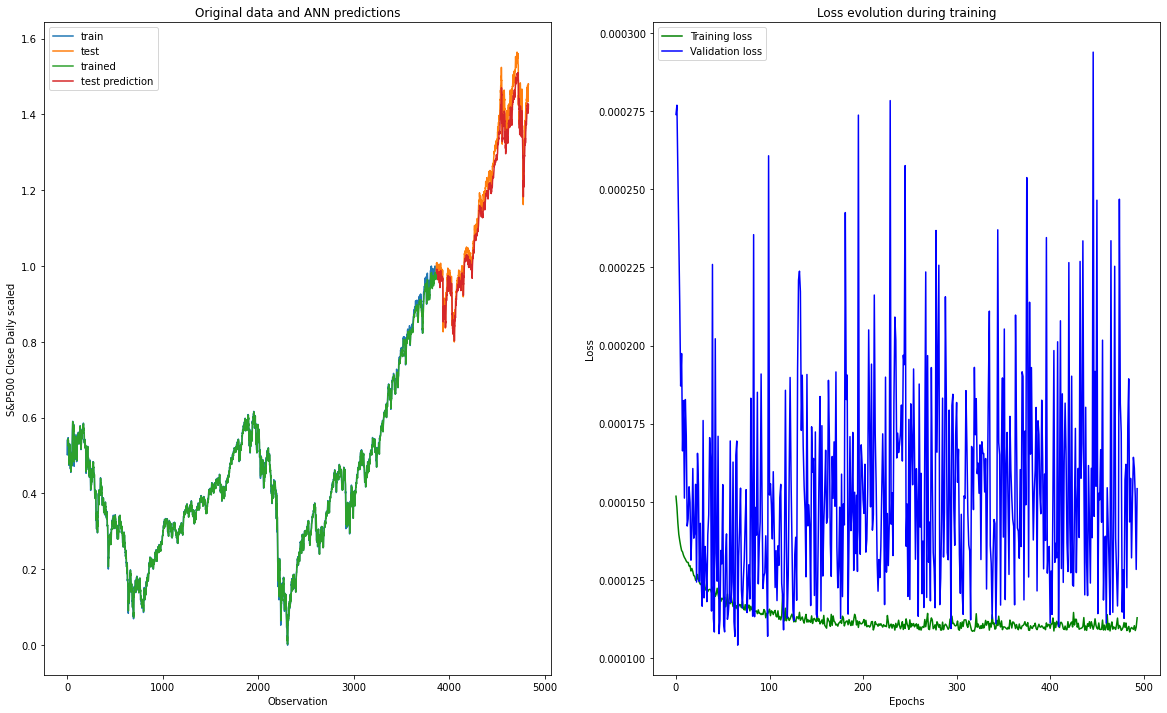

In [ ]:
X_train, y_train = prepare_time_series(
    train_scaled, train_scaled, best_window_size)
X_test, y_test = prepare_time_series(
    test_scaled, test_scaled, best_window_size)
ann_train_loss = ann.evaluate(x=X_train,
    y=y_train,
    batch_size=p["batch_size"])
ann_test_loss = ann.evaluate(x=X_test,
    y=y_test,
    batch_size=p["batch_size"])
y_train_pred = ann.predict(X_train)
y_test_pred = ann.predict(X_test)

print("ANN train: {}".format(ann_train_loss))
print("ANN test: {}".format(ann_test_loss))
#print("R2 score of a trivial predictor on train data:\t{:0.8f}".
#        format(r2_score(y_train[1:], y_train[:-1])))
#print("R2 score of a trivial predictor on test data:\t{:0.8f}".
#        format(r2_score(y_test[1:], y_test[:-1])))
print("MSE of a trivial predictor on train data:\t{:0.8f}".
        format(mean_squared_error(y_train[1:], y_train[:-1])))
print("MSE of a trivial predictor on test data:\t{:0.8f}".
        format(mean_squared_error(y_test[1:], y_test[:-1])))
#print("The R2 score on the Train set is:\t{:0.8f}".
#        format(r2_score(y_train, y_train_pred)))
#print("The R2 score on the Test set is:\t{:0.8f}".
#        format(r2_score(y_test, y_test_pred)))
print("MSE of the trained ANN on train data:\t{:0.8f}".
        format(mean_squared_error(y_train, y_train_pred)))
print("MSE of the trained ANN on test data:\t{:0.8f}".
        format(mean_squared_error(y_test, y_test_pred)))

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
plt.plot(range(test_split), train_scaled, label="train")
plt.plot(range(test_split, len(df)), test_scaled, label="test")
plt.plot(range(best_window_size, best_window_size + len(y_train_pred)),
            y_train_pred, label="trained")
plt.plot(range(best_window_size + test_split, best_window_size + test_split + len(y_test_pred)),
            y_test_pred, label="test prediction")
plt.title("Original data and ANN predictions")
plt.xlabel("Observation")
plt.ylabel("S&P500 Close Daily scaled")
plt.legend()
#plt.show()  # no subplot

skip = 6  # si los primeros valores son muy altos se pueden eliminar
# del gráfico para evitar que afecten la escala automática
# avoid autoscale issues
#plt.figure(figsize=(10,12))  # no subplot
plt.subplot(122)
plt.plot(history.history["loss"][skip:], "g",
            label="Training loss")
if (p["val_split"] != 0.0):
    plt.plot(history.history["val_loss"][skip:], "b",
                label="Validation loss")
plt.title("Loss evolution during training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


```
# resultados variando el optimizador
best_ann = (149, 18, 71)  # con 10% de mutación
best_ann = (33, 14, 78)  # con 5% de mutación
Test loss
adamax   0.00017806104733608663 low sigma
adam     0.0002559765998739749 medium sigma
nadam    0.0002807788841892034 high sigma
sgd      0.0015213494189083576 smooth
rmsprop  0.002701616147533059 high sigma
adagrad  0.010729542002081871 smooth
ftrl     0.10698116570711136 bad
adadelta 0.4015085995197296 bad
best_ann = (27, 18, 25)  # con 1% de mutación
```

